In [ ]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Работа с данными

### Считывание и краткий анализ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_train.csv')
# df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [ ]:
df['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

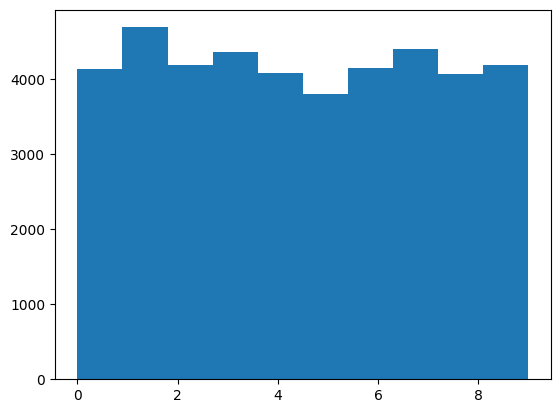

In [ ]:
plt.hist(df['label'], bins = 10)

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32)

In [ ]:
ds.shape

torch.Size([42000, 785])

### Dataset и Dataloader

In [ ]:
border = int(0.8*len(ds[:,0])) #для разделения на тренировочный и валидационный датасеты
print(border)
X = ds[:border,1:]/255 # нормализованный тензор значений пикселей
y = ds[:border,0]
print(X.shape)
print(y.shape)

33600
torch.Size([33600, 784])
torch.Size([33600])


In [ ]:
train_dataset = torch.utils.data.TensorDataset(X, y) #создание датасета

In [ ]:
X = ds[border:,1:]/255 # нормализованный тензор значений пикселей
y = ds[border:,0]
val_dataset = torch.utils.data.TensorDataset(X, y)
print(X.shape)
print(y.shape)

torch.Size([8400, 784])
torch.Size([8400])


#### Визуализация данных из  тензора и датасета

In [ ]:
ds[0, 1:].numpy().reshape(28,28).shape

(28, 28)

tensor(3.)


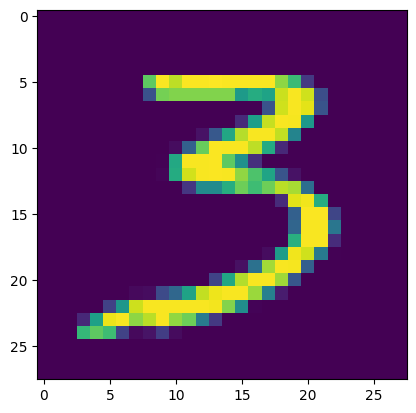

In [ ]:
plt.imshow(ds[25, 1:].numpy().reshape(28,28))
print(ds[25,0])

tensor(3.)


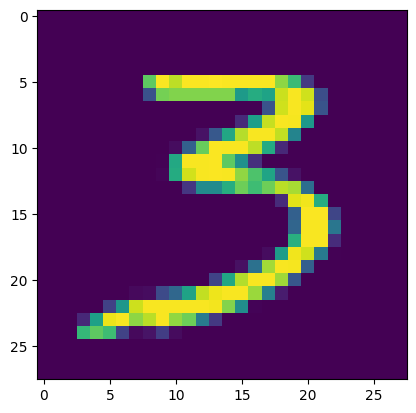

In [ ]:
plt.imshow(train_dataset[25][0].numpy().reshape(28,28))
print(train_dataset[25][1])

#### Создание загрузчика данных

In [ ]:
batch_size = 10
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
for digit, label in train_dataloader:
  print(digit.shape)
  print(label.shape)
  break


torch.Size([10, 784])
torch.Size([10])


In [ ]:
digit[0]

In [ ]:
label[0]

tensor(7)

# Нейронная сеть

In [ ]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
# device  = "cpu"
device

'cuda'

In [ ]:
class MyDigitRecognizer(nn.Module):
  def __init__(self, prob):
    super().__init__()

    self.l1 = nn.Linear(784, 300)
    self.l2 = nn.Linear(300, 100)
    self.l3 = nn.Linear(100, 10)
    self.dropout = nn.Dropout(p=prob) #для регуляризации обучени (чтобы не переобучалась)

    self.act_fn = nn.ReLU()

  def forward(self, x):
    x = self.l1(self.dropout(x))
    # x = self.l1(x)
    x = self.act_fn(x)
    x = self.l2(self.dropout(x))
    # x = self.l2(x)
    x = self.act_fn(x)
    x = self.l3(x)

    return x

In [ ]:
p = 0.25
model = MyDigitRecognizer(p)

In [ ]:
# функция потерь

loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# model.parameters - веса и смещения модели
# momentum - чтобы не застревать в локальных минимумах

In [ ]:
def accuracy (prediction, label):
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  # равны ли индексы максимальных элементов
  # print(answer)
  # print(answer.sum())
  return answer.mean()

### Обучение 1 вариант

In [ ]:
max_acc = 0

In [ ]:
model = model.to(device)
loss_fn = loss_fn.to(device)

epochs = 70

for e in range(epochs):

  model.train()

  loss_train = 0
  acc_train = 0

  for digit, label in tqdm(train_dataloader):
    optimizer.zero_grad()

    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    loss = loss_fn(prediction, label)
    loss.backward() #подсчёт градиентов
    loss_train += loss.item()

    optimizer.step()

    acc_train += accuracy(prediction.cpu(), label.cpu())

  # Валидация модели после обучения на каждой эпохе
  acc_val = 0

  model.eval()

  for digit, label in val_dataloader:
      digit = digit.to(device)
      label = label.to(device)

      # превращение label в вектор вероятностей (3 -> 00010000000)
      label = label.long() # так как аргумент one_hot должен быть целым
      label = F.one_hot(label, 10).float()

      prediction = model(digit)

      acc_val += accuracy(prediction.cpu(), label.cpu())

  if (acc_val/len(val_dataloader)) > max_acc:
      print("-------------Сохраниение модели-------------")
      max_acc = acc_val/len(val_dataloader)
      torch.save(model, '/content/drive/MyDrive/ML/ML_files/mnist_model.pth')

  print(f'epoch: {e}, looss: {loss_train/len(train_dataloader)}, accuracy: {acc_train/len(train_dataloader)}')
  print(f'Accuracy val: {acc_val/len(val_dataloader)}')


  0%|          | 0/3360 [00:00<?, ?it/s]<ipython-input-174-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 3360/3360 [00:07<00:00, 425.02it/s]


epoch: 0, looss: 0.9462191808325726, accuracy: 0.7278869047619182
Accuracy val: 0.9003571428571363


100%|██████████| 3360/3360 [00:07<00:00, 424.24it/s]


epoch: 1, looss: 0.37794471651238076, accuracy: 0.8876488095238332
Accuracy val: 0.9269047619047557


100%|██████████| 3360/3360 [00:07<00:00, 459.75it/s]


epoch: 2, looss: 0.2963449787426119, accuracy: 0.9108035714285964
Accuracy val: 0.9415476190476136


100%|██████████| 3360/3360 [00:07<00:00, 424.24it/s]


epoch: 3, looss: 0.24190642908963908, accuracy: 0.9265773809524042
Accuracy val: 0.9527380952380906


100%|██████████| 3360/3360 [00:07<00:00, 471.03it/s]


epoch: 4, looss: 0.20749658319054148, accuracy: 0.9368154761904991
Accuracy val: 0.959523809523805


100%|██████████| 3360/3360 [00:08<00:00, 415.27it/s]


epoch: 5, looss: 0.18226147153660088, accuracy: 0.9450892857143093
Accuracy val: 0.96428571428571


100%|██████████| 3360/3360 [00:07<00:00, 450.32it/s]


epoch: 6, looss: 0.16285808039593533, accuracy: 0.9507738095238304
Accuracy val: 0.9664285714285671


100%|██████████| 3360/3360 [00:07<00:00, 444.04it/s]


epoch: 7, looss: 0.14921122682538962, accuracy: 0.9553571428571614
Accuracy val: 0.9665476190476148


100%|██████████| 3360/3360 [00:07<00:00, 437.71it/s]


epoch: 8, looss: 0.13632801767997166, accuracy: 0.957708333333351
Accuracy val: 0.9703571428571388


100%|██████████| 3360/3360 [00:07<00:00, 469.33it/s]


epoch: 9, looss: 0.1268626373893009, accuracy: 0.9598511904762078
Accuracy val: 0.9726190476190443


100%|██████████| 3360/3360 [00:07<00:00, 430.74it/s]


epoch: 10, looss: 0.11598197415625605, accuracy: 0.9640476190476368
Accuracy val: 0.973928571428568


100%|██████████| 3360/3360 [00:07<00:00, 471.71it/s]


epoch: 11, looss: 0.10975902012691048, accuracy: 0.9655654761904919
Accuracy val: 0.9727380952380918


100%|██████████| 3360/3360 [00:08<00:00, 409.80it/s]


epoch: 12, looss: 0.10661980012989392, accuracy: 0.9663095238095405
Accuracy val: 0.9771428571428541


100%|██████████| 3360/3360 [00:07<00:00, 453.30it/s]


epoch: 13, looss: 0.0995663088761787, accuracy: 0.9685416666666817
Accuracy val: 0.9747619047619013


100%|██████████| 3360/3360 [00:07<00:00, 431.84it/s]


epoch: 14, looss: 0.09377274276622259, accuracy: 0.9701488095238242
Accuracy val: 0.9740476190476155


100%|██████████| 3360/3360 [00:07<00:00, 441.24it/s]


epoch: 15, looss: 0.0913244864842844, accuracy: 0.9706845238095382
Accuracy val: 0.9764285714285681


100%|██████████| 3360/3360 [00:07<00:00, 450.76it/s]


epoch: 16, looss: 0.08467483254310407, accuracy: 0.9728869047619167
Accuracy val: 0.9759523809523777


100%|██████████| 3360/3360 [00:07<00:00, 423.00it/s]


epoch: 17, looss: 0.08301439218747483, accuracy: 0.9717559523809667
Accuracy val: 0.9764285714285682


100%|██████████| 3360/3360 [00:07<00:00, 465.55it/s]


epoch: 18, looss: 0.0785559258515258, accuracy: 0.9755059523809649
Accuracy val: 0.9767857142857109


100%|██████████| 3360/3360 [00:08<00:00, 415.99it/s]


epoch: 19, looss: 0.07647578958779896, accuracy: 0.9755654761904894
Accuracy val: 0.976309523809521


100%|██████████| 3360/3360 [00:07<00:00, 449.37it/s]


epoch: 20, looss: 0.0704238954813155, accuracy: 0.9772916666666787
Accuracy val: 0.9776190476190444


100%|██████████| 3360/3360 [00:07<00:00, 422.30it/s]


epoch: 21, looss: 0.07068132399107137, accuracy: 0.9763095238095361
Accuracy val: 0.9796428571428543


100%|██████████| 3360/3360 [00:07<00:00, 434.72it/s]


epoch: 22, looss: 0.06870299688875353, accuracy: 0.9777976190476303
Accuracy val: 0.9784523809523775


100%|██████████| 3360/3360 [00:07<00:00, 452.50it/s]


epoch: 23, looss: 0.0646713752626727, accuracy: 0.9783035714285823
Accuracy val: 0.9796428571428542


100%|██████████| 3360/3360 [00:08<00:00, 417.81it/s]


epoch: 24, looss: 0.06663818087151326, accuracy: 0.9790476190476293
Accuracy val: 0.9788095238095209


100%|██████████| 3360/3360 [00:07<00:00, 470.28it/s]


epoch: 25, looss: 0.06413966748082853, accuracy: 0.9785119047619149
Accuracy val: 0.9780952380952349


100%|██████████| 3360/3360 [00:08<00:00, 413.61it/s]


epoch: 26, looss: 0.06203567736608117, accuracy: 0.9797916666666776
Accuracy val: 0.9792857142857112


100%|██████████| 3360/3360 [00:07<00:00, 444.61it/s]


epoch: 27, looss: 0.059111281552091416, accuracy: 0.9810416666666771
Accuracy val: 0.9789285714285683


100%|██████████| 3360/3360 [00:07<00:00, 431.55it/s]


epoch: 28, looss: 0.05803558258297753, accuracy: 0.9806547619047727
Accuracy val: 0.9813095238095211


100%|██████████| 3360/3360 [00:07<00:00, 426.41it/s]


epoch: 29, looss: 0.05619822325995756, accuracy: 0.981666666666676
Accuracy val: 0.9799999999999971


100%|██████████| 3360/3360 [00:07<00:00, 452.07it/s]


epoch: 30, looss: 0.05553979996843899, accuracy: 0.981666666666676
Accuracy val: 0.9777380952380922


100%|██████████| 3360/3360 [00:08<00:00, 419.07it/s]


epoch: 31, looss: 0.05318537500551039, accuracy: 0.9815773809523908
Accuracy val: 0.9803571428571399


100%|██████████| 3360/3360 [00:07<00:00, 459.66it/s]


epoch: 32, looss: 0.04990516855235845, accuracy: 0.9836309523809612
Accuracy val: 0.9801190476190446


100%|██████████| 3360/3360 [00:07<00:00, 421.29it/s]


epoch: 33, looss: 0.049101367632635, accuracy: 0.9841369047619131
Accuracy val: 0.9798809523809492


100%|██████████| 3360/3360 [00:07<00:00, 434.46it/s]


epoch: 34, looss: 0.05146977010154528, accuracy: 0.982470238095247
Accuracy val: 0.9809523809523781


100%|██████████| 3360/3360 [00:07<00:00, 437.26it/s]


epoch: 35, looss: 0.04710373198467301, accuracy: 0.984434523809532
Accuracy val: 0.9803571428571399


100%|██████████| 3360/3360 [00:07<00:00, 423.34it/s]


epoch: 36, looss: 0.048706670415866224, accuracy: 0.9840178571428658
Accuracy val: 0.9819047619047594


100%|██████████| 3360/3360 [00:07<00:00, 460.46it/s]


epoch: 37, looss: 0.04761433702424743, accuracy: 0.9843750000000082
Accuracy val: 0.9808333333333306


100%|██████████| 3360/3360 [00:08<00:00, 419.17it/s]


epoch: 38, looss: 0.04574840187924971, accuracy: 0.9843452380952465
Accuracy val: 0.9811904761904734


100%|██████████| 3360/3360 [00:07<00:00, 468.68it/s]


epoch: 39, looss: 0.04421451091476402, accuracy: 0.9855654761904836
Accuracy val: 0.9820238095238066


100%|██████████| 3360/3360 [00:07<00:00, 428.64it/s]


-------------Сохраниение модели-------------
epoch: 40, looss: 0.04596161131462287, accuracy: 0.9843452380952467
Accuracy val: 0.9833333333333307


100%|██████████| 3360/3360 [00:07<00:00, 432.92it/s]


epoch: 41, looss: 0.04399119805709309, accuracy: 0.9850892857142934
Accuracy val: 0.9817857142857115


100%|██████████| 3360/3360 [00:07<00:00, 449.60it/s]


-------------Сохраниение модели-------------
epoch: 42, looss: 0.0418441702521672, accuracy: 0.9863392857142929
Accuracy val: 0.9834523809523783


100%|██████████| 3360/3360 [00:08<00:00, 416.76it/s]


epoch: 43, looss: 0.042167662847980736, accuracy: 0.9854761904761989
Accuracy val: 0.9824999999999974


100%|██████████| 3360/3360 [00:07<00:00, 460.82it/s]


-------------Сохраниение модели-------------
epoch: 44, looss: 0.04088194024671364, accuracy: 0.9863392857142931
Accuracy val: 0.9834523809523784


100%|██████████| 3360/3360 [00:08<00:00, 405.96it/s]


epoch: 45, looss: 0.04264043100736406, accuracy: 0.9851785714285795
Accuracy val: 0.9817857142857116


100%|██████████| 3360/3360 [00:08<00:00, 418.72it/s]


epoch: 46, looss: 0.03970565689982041, accuracy: 0.9866666666666746
Accuracy val: 0.9823809523809496


100%|██████████| 3360/3360 [00:07<00:00, 440.77it/s]


epoch: 47, looss: 0.041334266583439354, accuracy: 0.9863392857142936
Accuracy val: 0.9827380952380925


100%|██████████| 3360/3360 [00:07<00:00, 432.81it/s]


epoch: 48, looss: 0.03892799439819314, accuracy: 0.9862797619047695
Accuracy val: 0.9823809523809496


100%|██████████| 3360/3360 [00:07<00:00, 459.14it/s]


epoch: 49, looss: 0.03939961424269251, accuracy: 0.9860714285714365
Accuracy val: 0.9811904761904733


100%|██████████| 3360/3360 [00:07<00:00, 421.79it/s]


epoch: 50, looss: 0.03694430694898011, accuracy: 0.9870833333333406
Accuracy val: 0.9826190476190447


100%|██████████| 3360/3360 [00:07<00:00, 456.42it/s]


epoch: 51, looss: 0.035995159753343574, accuracy: 0.9874702380952447
Accuracy val: 0.982976190476188


100%|██████████| 3360/3360 [00:07<00:00, 420.99it/s]


epoch: 52, looss: 0.038519804652806584, accuracy: 0.9872023809523887
Accuracy val: 0.9827380952380924


100%|██████████| 3360/3360 [00:07<00:00, 450.07it/s]


epoch: 53, looss: 0.03853433199845372, accuracy: 0.9874404761904833
Accuracy val: 0.9824999999999972


100%|██████████| 3360/3360 [00:07<00:00, 440.69it/s]


epoch: 54, looss: 0.03693122941440704, accuracy: 0.9878571428571492
Accuracy val: 0.9822619047619021


100%|██████████| 3360/3360 [00:07<00:00, 422.40it/s]


epoch: 55, looss: 0.03588067741410739, accuracy: 0.9882440476190544
Accuracy val: 0.9827380952380925


100%|██████████| 3360/3360 [00:07<00:00, 456.39it/s]


epoch: 56, looss: 0.036573951303503605, accuracy: 0.9879464285714353
Accuracy val: 0.9820238095238066


100%|██████████| 3360/3360 [00:08<00:00, 413.64it/s]


epoch: 57, looss: 0.035618843350173096, accuracy: 0.9884523809523882
Accuracy val: 0.9808333333333303


100%|██████████| 3360/3360 [00:07<00:00, 460.54it/s]


epoch: 58, looss: 0.03452970861778064, accuracy: 0.9883333333333397
Accuracy val: 0.9809523809523782


100%|██████████| 3360/3360 [00:08<00:00, 406.46it/s]


epoch: 59, looss: 0.03579670579470759, accuracy: 0.9872023809523888
Accuracy val: 0.9813095238095211


100%|██████████| 3360/3360 [00:07<00:00, 448.06it/s]


epoch: 60, looss: 0.03349404281006325, accuracy: 0.9883035714285783
Accuracy val: 0.9828571428571402


100%|██████████| 3360/3360 [00:07<00:00, 438.61it/s]


epoch: 61, looss: 0.03127812999457804, accuracy: 0.9894940476190537
Accuracy val: 0.9828571428571402


100%|██████████| 3360/3360 [00:07<00:00, 424.27it/s]


epoch: 62, looss: 0.03424573511577018, accuracy: 0.9879761904761966
Accuracy val: 0.982976190476188


100%|██████████| 3360/3360 [00:07<00:00, 463.07it/s]


epoch: 63, looss: 0.0334762685599661, accuracy: 0.9886607142857206
Accuracy val: 0.9830952380952352


100%|██████████| 3360/3360 [00:08<00:00, 408.82it/s]


epoch: 64, looss: 0.03318178276669988, accuracy: 0.9888392857142919
Accuracy val: 0.9830952380952354


100%|██████████| 3360/3360 [00:07<00:00, 463.87it/s]


epoch: 65, looss: 0.03386436707419009, accuracy: 0.9877976190476263
Accuracy val: 0.98285714285714


100%|██████████| 3360/3360 [00:07<00:00, 422.10it/s]


epoch: 66, looss: 0.03055591447435458, accuracy: 0.9896130952381008
Accuracy val: 0.9824999999999969


100%|██████████| 3360/3360 [00:07<00:00, 441.97it/s]


epoch: 67, looss: 0.030977467026787865, accuracy: 0.9900892857142913
Accuracy val: 0.9832142857142829


100%|██████████| 3360/3360 [00:07<00:00, 445.94it/s]


epoch: 68, looss: 0.03140707220196646, accuracy: 0.9893452380952438
Accuracy val: 0.9827380952380923


100%|██████████| 3360/3360 [00:08<00:00, 413.46it/s]


-------------Сохраниение модели-------------
epoch: 69, looss: 0.03075075119664226, accuracy: 0.9899107142857202
Accuracy val: 0.9835714285714261


In [ ]:
# Загрузка весов сохраённой модели
weights = torch.load('/content/drive/MyDrive/ML/ML_files/mnist_model.pth')
model.load_state_dict(weights.state_dict())

<All keys matched successfully>

### Валидация

In [ ]:
acc_val = 0

model.eval()

for digit, label in val_dataloader:
    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    acc_val += accuracy(prediction.cpu(), label.cpu())

print(f'accuracy: {acc_val/len(val_dataloader)}')

<ipython-input-174-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)


accuracy: 0.9835714285714261


# Формирование  сабмита

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/mnist_test.csv')

In [ ]:
ds = torch.tensor(df.values, dtype=torch.float32) / 255.0
# нормализованный тензор значений пикселей

ds.shape

torch.Size([28000, 784])

In [ ]:
dataset = torch.utils.data.TensorDataset(ds)
len(dataset)

28000

In [ ]:
batch_size = 16
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
for digit in test_dataloader:
  print(type(digit[0]))
  break

<class 'torch.Tensor'>


In [ ]:
# Функция для получения предсказаний модели
def get_predictions(model, dataloader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for digit in test_dataloader:
            digit[0] = digit[0].to(device)
            output = model(digit[0])
            predictions.extend(output.argmax(1).cpu().numpy())

    return predictions

In [ ]:
predicted_labels = get_predictions(model, test_dataloader)

In [ ]:
# Формирование submission DataFrame
submission_df = pd.DataFrame({
    'ImageId': np.arange(1, len(df) + 1),
    'Label': predicted_labels
})


In [ ]:
submission_df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


2          0          9          9          3          7          0          3          0          3          

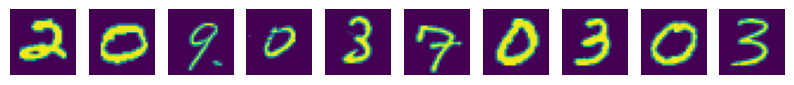

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 2))
for i in range (10):
  print(predicted_labels[i], end = '          ')
  axes[i].imshow(dataset[i][0].numpy().reshape(28,28))
  axes[i].axis('off')

In [ ]:
# Сохранение DataFrame в CSV файл
submission_df.to_csv('/content/drive/MyDrive/ML/ML_files/submission.csv', index=False)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/submission.csv')
df

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
